<a href="https://colab.research.google.com/github/priyankachahal/student_research/blob/master/ecg_project_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install -q https://github.com/neuropsychology/NeuroKit.py/zipball/master

     - 99.7MB 217kB/s
     |████████████████████████████████| 6.6MB 2.6MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 


In [3]:
!pip install joblib

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os
import sys
import glob
import math
import pickle

import matplotlib.pyplot as plt
import neurokit as nk
import numpy as np
from numpy import where
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.decomposition import PCA

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

from keras.layers import Dense, LSTM, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [0]:
# paths for different type of files
ECG_VALUES_FILES_PATH = '/content/drive/My Drive/Final Project/dataset/ecg-bg/data/ECG'
DATA_FRAME_FILE_PATH = '/content/drive/My Drive/Final Project/dataset/ecg-bg/ecg_reading_data_frame.csv'
META_DATA_FILE_PATH = '/content/drive/My Drive/Final Project/dataset/ecg-bg/data/meta.csv'
R_PEAK_DATA_FILE_PATH = '/content/drive/My Drive/Final Project/dataset/ecg-bg/rpeak-data-label.txt'

In [0]:
def extract_filename_from_path(path):
  return (os.path.split(path)[1])

In [0]:
def get_input_dataframe(use_data_frame_file = True):
  # read the labels from meta data and append them in the end
  meta_data_frame = pd.read_csv(META_DATA_FILE_PATH, engine='python',skiprows = 1, names=['Id',	'Date',	'Time',	'Age',	'Gender',	'Height',	'Weight',	'Hr',	'G'])
  ecg_labels_dict = {}
  for index, row in meta_data_frame.iterrows():
    if (int(row["G"]) > 140):
      ecg_labels_dict[row["Id"]] = 1
    else:
      ecg_labels_dict[row["Id"]] = 0
      # ecg_labels_dict[row["Id"]] = int(row["G"])
  # read the ecg values either from pre-calculated file or from each file by file.
  ecg_values_data_frame = pd.DataFrame()
  if use_data_frame_file:
      ecg_values_data_frame = pd.read_csv(DATA_FRAME_FILE_PATH, engine='python')
  else:
    all_files = glob.glob(ECG_VALUES_FILES_PATH + '/*.csv')
    li_df = []
    counter = 0
    for filename in all_files:
      df = pd.read_csv(filename, usecols=[1], engine='python')
      df = df.transpose();
      df.insert(0, 'fn', extract_filename_from_path(filename))
      li_df.append(df)
      counter = counter + 1
      if counter % 10 == 0:
        print(counter)
    ecg_values_data_frame = pd.concat(li_df, axis=0, ignore_index=True)
  label_serries_arr = []
  # iterate over file name column so that we can create a corresponding column for labels to be appended to ecg_values_data_frame
  for filename_col in ecg_values_data_frame[['fn']]:
    print(ecg_values_data_frame[filename_col].values.shape)
    for index, x in np.ndenumerate(ecg_values_data_frame[filename_col].values):
      key = x.replace(".csv", "")
      label_serries_arr.append(ecg_labels_dict[key])
  label_serries = pd.Series(data=label_serries_arr)
  ecg_values_data_frame['labels'] = label_serries
  return ecg_values_data_frame

In [32]:
ecg_values_data_frame_with_file_name = get_input_dataframe()
ecg_values_data_frame = ecg_values_data_frame_with_file_name.drop('fn', 1)
ecg_values = ecg_values_data_frame.values

(2238,)


In [40]:
ecg_values_data_frame_with_file_name[:5]

fn           0           1           2  ...  51675  51676  51677  labels
0  956_1.csv   65.347867  197.594708  324.101847  ...    NaN    NaN    NaN       0
1  869_1.csv   66.426777  197.459011  322.547138  ...    NaN    NaN    NaN       0
2  961_1.csv  110.166982  248.791284  381.362293  ...    NaN    NaN    NaN       1
3  403_2.csv   58.463016  188.841826  313.529000  ...    NaN    NaN    NaN       0
4  863_2.csv   55.497380  188.700609  316.456256  ...    NaN    NaN    NaN       0

[5 rows x 51680 columns]

In [34]:
ecg_values_data_frame_with_file_name.shape

(2238, 51680)

In [11]:
ecg_values_data_frame.shape

(2238, 51679)

In [10]:
ecg_values_data_frame[:5]

0           1           2           3  ...  51675  51676  51677  labels
0   65.347867  197.594708  324.101847  442.088797  ...    NaN    NaN    NaN       0
1   66.426777  197.459011  322.547138  438.949837  ...    NaN    NaN    NaN       0
2  110.166982  248.791284  381.362293  505.035991  ...    NaN    NaN    NaN       1
3   58.463016  188.841826  313.529000  429.856278  ...    NaN    NaN    NaN       0
4   55.497380  188.700609  316.456256  435.968942  ...    NaN    NaN    NaN       0

[5 rows x 51679 columns]

In [0]:
def get_dense_data_vals(processed_ecg):
  rpeaks_inds = list(processed_ecg['ECG']['R_Peaks'])
  ECG_Filtered = list(processed_ecg['df']['ECG_Filtered'])

  dense_data_vals = []
  len_of_ECG = len(ECG_Filtered) # ECG data sampled at 1000Hz.
  left_algn_ecg = 150            # 150 ms left of Rpeak
  right_algn_ecg = 250           # 250 ms right of rpeak
  sample_step = 1
  seg_number = 0
  for each_rpeak_ind in rpeaks_inds :
      temp_data = []
      temp_inds = []
      temp_dict = {}
      for all_data in range((each_rpeak_ind - left_algn_ecg), (each_rpeak_ind + right_algn_ecg), sample_step) :
          temp_inds.append(all_data)
          temp_data.append(ECG_Filtered[all_data])
      temp_dict['inds'] = temp_inds
      temp_dict['sig'] = temp_data
      temp_dict['rpeak'] = ECG_Filtered[each_rpeak_ind]
      temp_dict['rpeak_ind'] = each_rpeak_ind
      temp_dict['seg_number'] = seg_number
      dense_data_vals.append(temp_dict)
      seg_number += 1
  return dense_data_vals

In [0]:
def getRPeaksLabelledFromFiducialPoints(data_frame):
  rpeak_list_labelled = []
  for index, row in data_frame.iterrows():
    np_temp = row.dropna().to_numpy()
    # https://neurokit.readthedocs.io/en/latest/documentation.html FIR = Finite Impulse Response filter, Band-pass filter (“bandpass”)
    processed_ecg = nk.ecg_process(np_temp,sampling_rate=1000,filter_type='FIR',filter_band='bandpass',filter_frequency=[1, 40],segmenter='hamilton',quality_model='default') 
    dense_data_vals = get_dense_data_vals(processed_ecg)
    rpeak_labeled = []
    for dense_data_val in dense_data_vals:
        rpeak_labeled.append(dense_data_val['rpeak']);
    # append the label
    rpeak_labeled.append(row['labels'])
    rpeak_list_labelled.append(rpeak_labeled)
  return rpeak_list_labelled

In [0]:
rpeak_labelled_list = getRPeaksLabelledFromFiducialPoints(ecg_values_data_frame)

In [0]:
with open(R_PEAK_DATA_FILE_PATH, "wb") as fp:
  pickle.dump(rpeak_labelled_list, fp)

In [0]:
with open(R_PEAK_DATA_FILE_PATH, "rb") as fp:   # Unpickling
  rpeak_labelled_list_loaded = pickle.load(fp)

In [0]:
def sample_training_dataset(input_values, percentage = 0.7):
  freqmap = np.array(np.unique(input_values[:, [input_values.shape[1] - 1]].astype(int), return_counts=True)).T
  print (freqmap)
  freqmap[:,1] = freqmap[:,1].astype(float) * percentage
  # stores the required freq of each label
  labelCountDict = {};
  for label, freq in freqmap:
    labelCountDict[label] = float(freq)
  print(labelCountDict)
  train_arr, test_arr = [], []
  # go through each row of input array after removing NaN
  for row in input_values:
    label_column_index = row[input_values.shape[1] - 1]
    # if we still have required freq of label, we add to train dataset or add to test dataset
    if labelCountDict[label_column_index] > 0:
      train_arr.append(row)
      labelCountDict[label_column_index] = labelCountDict[label_column_index] - 1
    else:
      test_arr.append(row)
  return np.array(train_arr), np.array(test_arr)

In [0]:
def getNumpyNDArray(rpeak_labelled):
  features = []
  labels = []
  for record in rpeak_labelled:
    labels.append(record[-1])
    record = record[:-1]
    features.append(record)
  print(features)
  features_df = pd.DataFrame(features)
  features_numpy_array = np.asarray(features_df)

  labels_df = pd.DataFrame(labels)
  labels_numpy_array = np.asarray(labels_df)

  return np.concatenate((features_numpy_array, labels_numpy_array), axis=1)

In [17]:
A = getNumpyNDArray(rpeak_labelled_list_loaded)

[[420.65129004240237, 429.9534269592119, 448.8732490858266, 445.5010774485969, 440.74132726544934, 390.51791553375284, 433.22548500870386, 455.0464273912184, 460.4869241653116, 440.98081420129154, 408.2381974449241, 444.42531935456066, 465.93937246283303, 452.2726585281427, 398.7317420376307, 370.37241089265586, 415.0325006205764, 432.93133088557994, 436.826633870267, 450.3632923564647, 400.25588723627095, 373.52379900035453, 445.3882720544457, 424.7430490011038, 443.3322555839299, 435.8113634408731, 401.1069158196645, 395.0687609098177, 434.2244071816326, 460.6784578851887, 471.32464441940306, 424.5067930457527, 382.28614979712154, 439.305232699319, 443.7876689708581, 453.7112620333696, 440.99087023026226, 386.97602538704786, 460.99276488046917, 461.4660012940982, 442.38663936738214, 382.55229584169507, 446.69946108937586, 453.53611409963963, 456.5493215059889, 417.57587083160047, 364.4834625434863, 317.89832158227523, 391.5459577905869, 441.409255955354, 446.56655478535174, 443.38399

In [0]:
A.shape

(2238, 124)

In [0]:
A[:5][:124]

array([[420.65129004, 429.95342696, 448.87324909, 445.50107745,
        440.74132727, 390.51791553, 433.22548501, 455.04642739,
        460.48692417, 440.9808142 , 408.23819744, 444.42531935,
        465.93937246, 452.27265853, 398.73174204, 370.37241089,
        415.03250062, 432.93133089, 436.82663387, 450.36329236,
        400.25588724, 373.523799  , 445.38827205, 424.743049  ,
        443.33225558, 435.81136344, 401.10691582, 395.06876091,
        434.22440718, 460.67845789, 471.32464442, 424.50679305,
        382.2861498 , 439.3052327 , 443.78766897, 453.71126203,
        440.99087023, 386.97602539, 460.99276488, 461.46600129,
        442.38663937, 382.55229584, 446.69946109, 453.5361141 ,
        456.54932151, 417.57587083, 364.48346254, 317.89832158,
        391.54595779, 441.40925596, 446.56655479, 443.38399015,
        378.19354552, 381.8714523 , 422.10524365, 420.71093066,
        430.09566285, 444.12793475, 369.26417332, 394.67630019,
        486.75732358,          nan,     

In [29]:
plt.figure(ecg_values_data_frame[:1],A[:1])

TypeError: ignored

In [22]:
A = getNumpyNDArray(rpeak_labelled_list_loaded)
train,test = sample_training_dataset(A, 0.9)

[[420.65129004240237, 429.9534269592119, 448.8732490858266, 445.5010774485969, 440.74132726544934, 390.51791553375284, 433.22548500870386, 455.0464273912184, 460.4869241653116, 440.98081420129154, 408.2381974449241, 444.42531935456066, 465.93937246283303, 452.2726585281427, 398.7317420376307, 370.37241089265586, 415.0325006205764, 432.93133088557994, 436.826633870267, 450.3632923564647, 400.25588723627095, 373.52379900035453, 445.3882720544457, 424.7430490011038, 443.3322555839299, 435.8113634408731, 401.1069158196645, 395.0687609098177, 434.2244071816326, 460.6784578851887, 471.32464441940306, 424.5067930457527, 382.28614979712154, 439.305232699319, 443.7876689708581, 453.7112620333696, 440.99087023026226, 386.97602538704786, 460.99276488046917, 461.4660012940982, 442.38663936738214, 382.55229584169507, 446.69946108937586, 453.53611409963963, 456.5493215059889, 417.57587083160047, 364.4834625434863, 317.89832158227523, 391.5459577905869, 441.409255955354, 446.56655478535174, 443.38399

In [23]:
print(train.shape)
print(test.shape)

(2014, 124)
(224, 124)


In [0]:
train_normal = train[train[:, -1]==0]
train_outliers = train[train[:, -1]==1]
train_normal = np.nan_to_num(train_normal)
test = np.concatenate((test, train_outliers))
test = np.nan_to_num(test)
test_y = test[:, -1]
test = test[:,:123]
train_normal = train_normal[:,:123] 

scaler = StandardScaler()
train_x = scaler.fit_transform(train_normal)
test_x = scaler.fit_transform(test)

In [25]:
print(train_normal.shape)
print(test.shape)

(1862, 123)
(376, 123)


In [0]:
outlier_prop = len(train_outliers) / len(train_normal) 

In [27]:
print('outlier_prop: ',outlier_prop)

outlier_prop:  0.08163265306122448


**One class svm with linear kernel replacing nan to 0**

False Positive Rate : [0.91715976 0.11594203]
False Negative Rate : [0.11594203 0.91715976]
Accuracy : [0.52393617 0.52393617]
              precision    recall  f1-score   support

         0.0       0.54      0.88      0.67       207
         1.0       0.37      0.08      0.14       169

    accuracy                           0.52       376
   macro avg       0.45      0.48      0.40       376
weighted avg       0.46      0.52      0.43       376

None


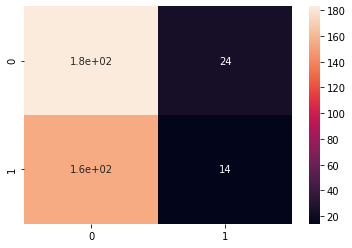

In [0]:
svm_linear = OneClassSVM(kernel='linear',nu=outlier_prop, gamma=0.00000001)
svm_linear.fit(train_normal)
y_pred_test = svm_linear.predict(test)
y_pred_test=np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test=np.where(y_pred_test==-1, 1, y_pred_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_y, y_pred_test)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(print(classification_report(test_y,y_pred_test)))

sns.heatmap(cnf_matrix, annot= True)

**one class svm with linear kernel dropping nan**

In [0]:
A = getNumpyNDArray(rpeak_labelled_list_loaded)
A = A[:, ~np.isnan(A).any(axis=0)]

train,test = sample_training_dataset(A, 0.9)
train_normal = train[train[:, -1]==0]
train_outliers = train[train[:, -1]==1]
test = np.concatenate((test, train_outliers))
test_y = test[:, -1]
test = test[:,:len(A[1])]
train_normal = train_normal[:,:len(A[1])]

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

outlier_prop = len(train_outliers) / len(train_normal)

False Positive Rate : [0.91715976 0.11594203]
False Negative Rate : [0.11594203 0.91715976]
Accuracy : [0.52393617 0.52393617]
              precision    recall  f1-score   support

         0.0       0.54      0.88      0.67       207
         1.0       0.37      0.08      0.14       169

    accuracy                           0.52       376
   macro avg       0.45      0.48      0.40       376
weighted avg       0.46      0.52      0.43       376



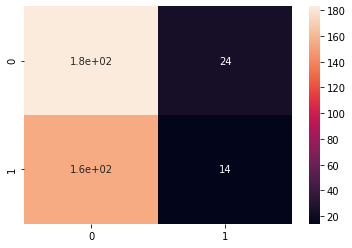

In [0]:
svm_linear = OneClassSVM(kernel='linear',nu=outlier_prop, gamma=0.00000001)
svm_linear.fit(train_normal)
y_pred_test = svm_linear.predict(test)
y_pred_test=np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test=np.where(y_pred_test==-1, 1, y_pred_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_y, y_pred_test)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(test_y,y_pred_test))

sns.heatmap(cnf_matrix, annot= True)

**one class svm with poly kernel**

False Positive Rate : [0.94674556 0.07729469]
False Negative Rate : [0.07729469 0.94674556]
Accuracy : [0.53191489 0.53191489]
              precision    recall  f1-score   support

         0.0       0.54      0.92      0.68       207
         1.0       0.36      0.05      0.09       169

    accuracy                           0.53       376
   macro avg       0.45      0.49      0.39       376
weighted avg       0.46      0.53      0.42       376

None


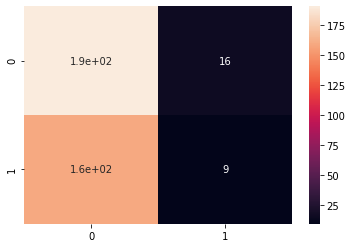

In [0]:
svm_poly = OneClassSVM(kernel='poly',degree=4,nu=outlier_prop, gamma=0.00000001) #degree=2 : 52% , gamma greater than this value doesn't have any impact but reducing the value decreases the accuracy 
svm_poly.fit(train_normal)
y_pred_test = svm_poly.predict(test)
y_pred_test=np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test=np.where(y_pred_test==-1, 1, y_pred_test)

cnf_matrix = confusion_matrix(test_y, y_pred_test)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(print(classification_report(test_y,y_pred_test)))

sns.heatmap(cnf_matrix, annot= True)

**one class svm with rbf kernel**

[[190  17]
 [141  28]]
False Positive Rate : [0.83431953 0.0821256 ]
False Negative Rate : [0.0821256  0.83431953]
Accuracy : [0.57978723 0.57978723]
              precision    recall  f1-score   support

         0.0       0.57      0.92      0.71       207
         1.0       0.62      0.17      0.26       169

    accuracy                           0.58       376
   macro avg       0.60      0.54      0.48       376
weighted avg       0.60      0.58      0.51       376

None


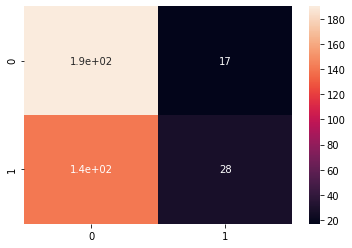

In [28]:
svm_rbf = OneClassSVM(kernel='rbf',nu=outlier_prop, gamma=0.00000001) # > or < gamma value decreases accuracy
svm_rbf.fit(train_normal)
y_pred_test = svm_rbf.predict(test)
y_pred_test=np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test=np.where(y_pred_test==-1, 1, y_pred_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_y, y_pred_test)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(print(classification_report(test_y,y_pred_test)))

sns.heatmap(cnf_matrix, annot= True)

one class svm with rbf kernel dropping nan values

In [0]:
A = getNumpyNDArray(rpeak_labelled_list_loaded)
A = A[:, ~np.isnan(A).any(axis=0)]

train,test = sample_training_dataset(A, 0.9)
train_normal = train[train[:, -1]==0]
train_outliers = train[train[:, -1]==1]
test = np.concatenate((test, train_outliers))
test_y = test[:, -1]
test = test[:,:len(A[1])]
train_normal = train_normal[:,:len(A[1])] 

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

outlier_prop = len(train_outliers) / len(train_normal)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_normal)
test_x = scaler.fit_transform(test)

# pca = PCA(n_components=5,random_state=42)  #doesn't make any difference
# train_x = pca.fit_transform(train_normal)
# test_x = pca.fit_transform(test)

[[188  19]
 [142  27]]
False Positive Rate : [0.84023669 0.09178744]
False Negative Rate : [0.09178744 0.84023669]
Accuracy : [0.57180851 0.57180851]
              precision    recall  f1-score   support

         0.0       0.57      0.91      0.70       207
         1.0       0.59      0.16      0.25       169

    accuracy                           0.57       376
   macro avg       0.58      0.53      0.48       376
weighted avg       0.58      0.57      0.50       376

None


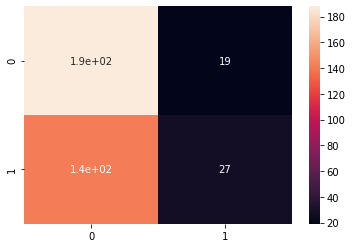

In [0]:
svm_rbf = OneClassSVM(kernel='rbf',nu=outlier_prop, gamma=0.00000001)
svm_rbf.fit(train_normal)
y_pred_test = svm_rbf.predict(test)
y_pred_test=np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test=np.where(y_pred_test==-1, 1, y_pred_test)

cnf_matrix = confusion_matrix(test_y, y_pred_test)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(print(classification_report(test_y,y_pred_test)))

sns.heatmap(cnf_matrix, annot= True)

In [0]:
# y_pred_test

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [0]:
# y_pred_test=np.where(y_pred_test==1, 0, y_pred_test)
# y_pred_test=np.where(y_pred_test==-1, 1, y_pred_test)

In [0]:
# y_pred_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

 ** Logistic Regression**

In [0]:
from sklearn.linear_model import LogisticRegression
A = getNumpyNDArray(rpeak_labelled_list_loaded)
A = A[:, ~np.isnan(A).any(axis=0)]

train,test = sample_training_dataset(A, 0.8)
train_x= train[:,:41]
train_y = train[:,-1]
test_x = test[:,:41]
test_y = test[:,-1]

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

pca = PCA(n_components=12,random_state=42)
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_x, train_y = sm.fit_resample(train_x, train_y)

clf = LogisticRegression(penalty='l2',C=3,random_state=42) #regularization C = 4
clf.fit(train_x,train_y)
y_predict = clf.predict(test_x)

[[262 152]
 [ 15  19]]
False Positive Rate : [0.44117647 0.36714976]
False Negative Rate : [0.36714976 0.44117647]
Accuracy : [0.62723214 0.62723214]
              precision    recall  f1-score   support

         0.0       0.95      0.63      0.76       414
         1.0       0.11      0.56      0.19        34

    accuracy                           0.63       448
   macro avg       0.53      0.60      0.47       448
weighted avg       0.88      0.63      0.71       448



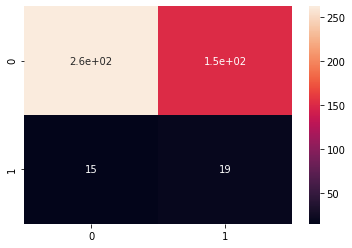

In [0]:
cnf_matrix = confusion_matrix(test_y, y_predict)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(test_y,y_predict))

sns.heatmap(cnf_matrix, annot= True)

**Linear SVM**

In [0]:
from sklearn import svm
A = getNumpyNDArray(rpeak_labelled_list_loaded)
A = A[:, ~np.isnan(A).any(axis=0)]
train,test = sample_training_dataset(A, 0.8)
train_x= train[:,:41]
train_y = train[:,-1]

sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_x, train_y = sm.fit_resample(train_x, train_y)

test_x = test[:,:41]
test_y = test[:,-1]

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

pca = PCA(n_components=15,random_state=42)
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

SVM = svm.LinearSVC(penalty='l2',C=60,random_state=42,multi_class='ovr')
SVM.fit(train_x, train_y)

y_predict = SVM.predict(test_x)

[[255 159]
 [ 12  22]]
False Positive Rate : [0.35294118 0.38405797]
False Negative Rate : [0.38405797 0.35294118]
Accuracy : [0.61830357 0.61830357]
              precision    recall  f1-score   support

         0.0       0.96      0.62      0.75       414
         1.0       0.12      0.65      0.20        34

    accuracy                           0.62       448
   macro avg       0.54      0.63      0.48       448
weighted avg       0.89      0.62      0.71       448



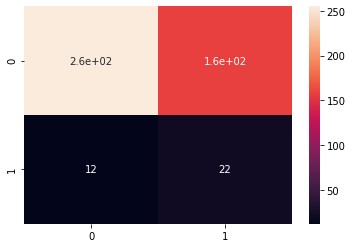

In [0]:
cnf_matrix = confusion_matrix(test_y, y_predict)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(test_y,y_predict))

sns.heatmap(cnf_matrix, annot= True)

**Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier
A = getNumpyNDArray(rpeak_labelled_list_loaded)
A = A[:, ~np.isnan(A).any(axis=0)]
train,test = sample_training_dataset(A, 0.8)
train_x= train[:,:41]
train_y = train[:,-1]

sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_x, train_y = sm.fit_resample(train_x, train_y)

test_x = test[:,:41]
test_y = test[:,-1]

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

pca = PCA(n_components=12,random_state=42)
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

RF = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=0) #depth =10 , 29,5 ,depth=20 class 1 is performing poorly 33,1
RF.fit(train_x, train_y)

y_predict = RF.predict(test_x)

[[296 118]
 [ 25   9]]
False Positive Rate : [0.73529412 0.28502415]
False Negative Rate : [0.28502415 0.73529412]
Accuracy : [0.68080357 0.68080357]
              precision    recall  f1-score   support

         0.0       0.92      0.71      0.81       414
         1.0       0.07      0.26      0.11        34

    accuracy                           0.68       448
   macro avg       0.50      0.49      0.46       448
weighted avg       0.86      0.68      0.75       448



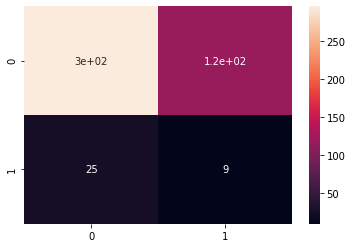

In [0]:
cnf_matrix = confusion_matrix(test_y, y_predict)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(test_y,y_predict))

sns.heatmap(cnf_matrix, annot= True)